Используя новый вариант построения круговых диаграмм (с учётом размеров угла) оценим качество только на предсказаниях.

In [1]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs, draw_all_rectangles
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams
from circle_diagram import calculate_penalty_for_diagrams

from utils import read_pickle, dump_pickle

In [5]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers_6_8 = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')
points_to_centers_3_4 = read_pickle('../dataset/100_points_to_cell_centers_12cells_3x4.pickle')

In [6]:
predictions_folder = '../dataset/predictions/'
predicts_osm_folder = 'predicts_osm'
rectangled_predicts_folder = 'rectangled_predicts_pixel'
objects_predicts_folder = 'rectangled_predicts_obj'

osm_objects_path = os.path.join(predictions_folder, predicts_osm_folder)

In [7]:
train_val_test = read_pickle("../dataset/train_val_test_split.pickle")
test_ids = train_val_test['test']

In [8]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)
print("Sectors count:", sectors_count)

Sectors count: 616


Отберём только те картинки, на которых есть шанс получить что-то лучше, чем рандом (должно быть больше одного объекта)

In [9]:
def get_all_tags(img_osm_object):
    return [o.tag for o in img_osm_object.osm_objects if o.tag != 'ridge' and o.tag != 'valley' ]

In [10]:
result_ids = []

i = 0

bad_count_before_100 = 0
bad_count_after_100 = 0

while len(result_ids) < 100:
    img_id = test_ids[i]
    
    try:
        img_osm_object = read_pickle(os.path.join(osm_objects_path, img_id + '.pickle'))
    except Exception as e:
        print(e)
        # Дальше, чем 100, предсказаний нет
        break
    tags = get_all_tags(img_osm_object)
    
    if len(tags) < 2:
        print(f"{i}:, image: {img_id}, tags: {tags}")
        if i < 100:
            bad_count_before_100 += 1
        else:
            bad_count_after_100 += 1
    else:
        result_ids.append(img_id)
        
    i += 1

1:, image: 9501, tags: []
4:, image: 10196, tags: []
6:, image: 11093, tags: []
7:, image: 11980, tags: []
10:, image: 11410, tags: []
11:, image: 16382, tags: []
13:, image: 9437, tags: []
15:, image: 1006, tags: []
16:, image: 3800, tags: []
18:, image: 16832, tags: ['water']
20:, image: 18649, tags: []
23:, image: 16577, tags: []
24:, image: 14357, tags: []
25:, image: 14705, tags: []
26:, image: 17506, tags: []
27:, image: 14406, tags: []
29:, image: 9463, tags: []
30:, image: 14706, tags: []
33:, image: 18004, tags: []
34:, image: 4221, tags: []
36:, image: 21615, tags: []
38:, image: 11947, tags: []
39:, image: 16286, tags: []
43:, image: 21799, tags: []
44:, image: 13603, tags: []
46:, image: 1869, tags: []
47:, image: 11859, tags: ['water']
48:, image: 202, tags: []
50:, image: 18478, tags: []
55:, image: 12939, tags: []
56:, image: 18421, tags: []
57:, image: 8750, tags: []
58:, image: 14014, tags: []
59:, image: 20030, tags: ['peak']
60:, image: 19572, tags: []
61:, image: 13

In [11]:
print(len(result_ids))

42


In [13]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
#         penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        penalties.append(calculate_penalty_for_diagrams(img_cds.circle_diagrams[i].sectors, agent_cd.sectors))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [14]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [15]:
def is_in_one_of_max_k(cell_probs, center_point_id, max_k):
    is_ok_for_different_k = []
    
    argsort = np.argsort(cell_probs)[::-1]
    for k in range(0, max_k):
        if argsort[k] == center_point_id:
            is_ok_for_different_k += [True for _ in range(max_k - k)]
            break
        else:
            is_ok_for_different_k.append(False)
        
    return is_ok_for_different_k

In [18]:
def calculate_precision_k_for_one(img_id, max_k):
    
    filename_pickle = img_id + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=False, with_angle_penalty=True)
    
    is_in_k_one_image = []
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm, with_angle_penalty=True)
#         agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers_6_8[agent_point[::-1]][::-1])

        is_in_k_one_point = is_in_one_of_max_k(cell_probs, center_point_id, max_k)
        is_in_k_one_image.append(is_in_k_one_point)
        
    return is_in_k_one_image

In [21]:
%%time
is_in_k_one_image = calculate_precision_k_for_one(result_ids[0], max_k=47)

CPU times: user 2.93 s, sys: 2.42 ms, total: 2.93 s
Wall time: 2.92 s


In [22]:
np.array(is_in_k_one_image)[:, 0].sum() / len(is_in_k_one_image)

0.55

In [23]:
np.array(is_in_k_one_image)[:, 1].sum() / len(is_in_k_one_image)

0.8

In [24]:
np.array(is_in_k_one_image)[:, 2].sum() / len(is_in_k_one_image)

0.87

In [25]:
is_in_k_one_image = np.array(is_in_k_one_image)

acc_k = []
for i in range(47):
    acc_k.append(is_in_k_one_image[:, i].sum() / is_in_k_one_image.shape[0])

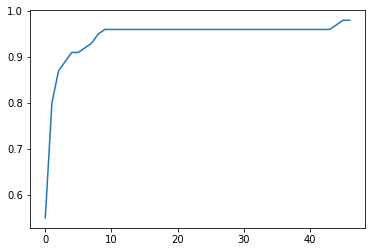

In [26]:
plt.plot(range(47), acc_k)

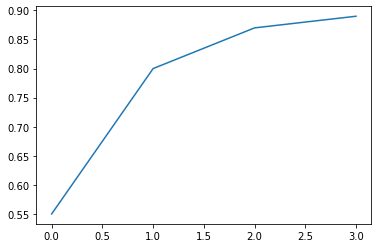

In [27]:
plt.plot(range(4), acc_k[:4])

In [28]:
%%time
is_in_k = []

for img_id in result_ids[:100]:
    
    is_in_k += calculate_precision_k_for_one(img_id, max_k=48)
    
    if len(is_in_k) % 200 == 0:
        print(len(is_in_k))
        

200


../utils.py:39: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
CPU times: user 2min 46s, sys: 151 ms, total: 2min 46s
Wall time: 2min 46s


In [29]:
is_in_k = np.array(is_in_k)

acc_k = []
for i in range(48):
    acc_k.append(is_in_k[:, i].sum() / is_in_k.shape[0])

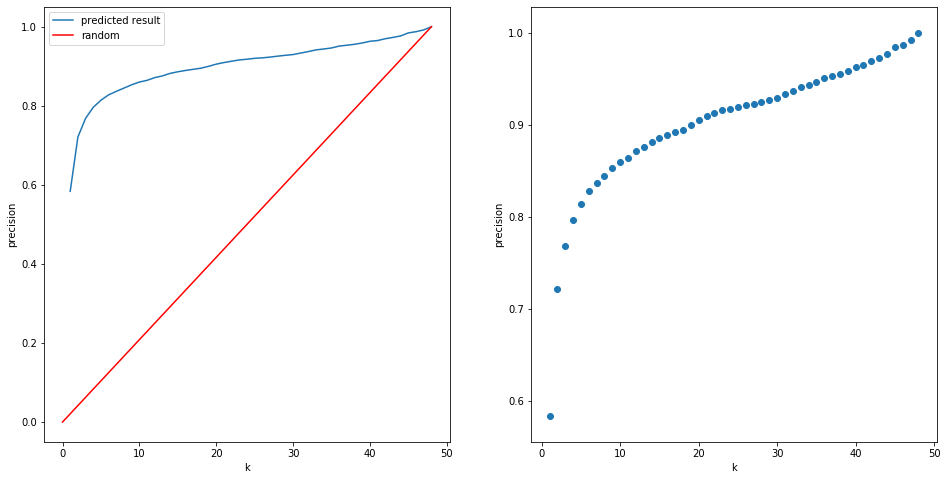

In [30]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.plot(range(1, 49), acc_k, label='predicted result')
plt.plot(range(49), [i / 48 for i in range(49)], color='red', label='random')
plt.xlabel('k')
plt.ylabel('precision')
plt.legend()

plt.subplot(122)
plt.scatter(range(1, 49), acc_k)
plt.xlabel('k')
plt.ylabel('precision')

plt.show()

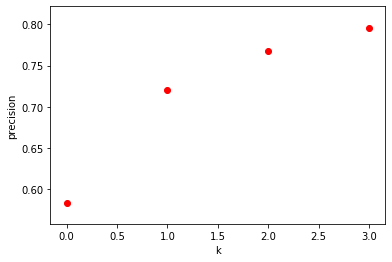

In [31]:
plt.scatter(range(4), acc_k[:4], color='red')
plt.xlabel('k')
plt.ylabel('precision')

plt.show()

In [32]:
for k in range(48):
    print(f"K: {k+1}, precision - {acc_k[k]}")

K: 1, precision - 0.5835714285714285
K: 2, precision - 0.7209523809523809
K: 3, precision - 0.768095238095238
K: 4, precision - 0.7961904761904762
K: 5, precision - 0.814047619047619
K: 6, precision - 0.8276190476190476
K: 7, precision - 0.8364285714285714
K: 8, precision - 0.8447619047619047
K: 9, precision - 0.8530952380952381
K: 10, precision - 0.86
K: 11, precision - 0.8642857142857143
K: 12, precision - 0.8711904761904762
K: 13, precision - 0.8754761904761905
K: 14, precision - 0.8819047619047619
K: 15, precision - 0.8859523809523809
K: 16, precision - 0.8892857142857142
K: 17, precision - 0.8921428571428571
K: 18, precision - 0.895
K: 19, precision - 0.8997619047619048
K: 20, precision - 0.9052380952380953
K: 21, precision - 0.9092857142857143
K: 22, precision - 0.9126190476190477
K: 23, precision - 0.915952380952381
K: 24, precision - 0.9176190476190477
K: 25, precision - 0.92
K: 26, precision - 0.9211904761904762
K: 27, precision - 0.9230952380952381
K: 28, precision - 0.925476

Проверим, есть ли случаи, когда качество получилось действительно высоким? (ну или хотя бы немного выше, чем обычно)

In [33]:
good_imgs = []
good_imgs_acc = []
good_is_in_1 = []

for i in range(len(result_ids)):
    local_is_in_1 = is_in_k[i * 100 : i * 100 + 100, 0]
    acc = local_is_in_1.sum() / 100
    if acc >= 0.75:
        good_imgs_acc.append(acc)
        good_imgs.append(result_ids[i])
        good_is_in_1.append(local_is_in_1)
        print(f"IMG_ID: {result_ids[i]}, acc: {acc}")

IMG_ID: 10818, acc: 0.76
IMG_ID: 5157, acc: 0.78


In [34]:
# А это неудачные случаи
bad_imgs = []
bad_imgs_acc = []
bad_is_in_1 = []

for i in range(len(result_ids)):
    local_is_in_1 = is_in_k[i * 100 : i * 100 + 100, 0]
    acc = local_is_in_1.sum() / 100
    if acc < 0.4:
        bad_imgs.append(result_ids[i])
        bad_imgs_acc.append(acc)
        bad_is_in_1.append(local_is_in_1)
        print(f"IMG_ID: {result_ids[i]}, acc: {acc}")

IMG_ID: 10798, acc: 0.34
IMG_ID: 14119, acc: 0.34
IMG_ID: 7496, acc: 0.31


In [35]:
img_acc = []

for i in range(len(result_ids)):
    img_acc.append(is_in_k[i * 100 : i * 100 + 100, 0].sum() / 100)

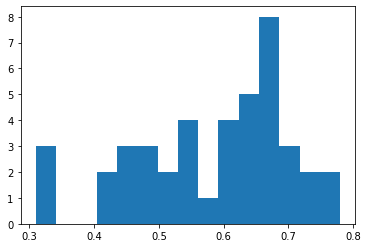

In [36]:
plt.hist(img_acc, bins=15)
plt.show()

Ну тут уже видно, что чаще качество более высокое

In [37]:
def get_all_objects_and_tags(img_osm_object):
    return [(o.tag, o.minlon, o.maxlat, o.maxlon, o.minlat) 
            for o in img_osm_object.osm_objects if o.tag != 'ridge' and o.tag != 'valley' ]

### Смотрим на картинки 

In [43]:
def calculate_cell_probs_for_all_points(img_id):
    point_to_probs = []
    
    filename_pickle = img_id + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=False, with_angle_penalty=True)
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm, with_angle_penalty=True)
#         agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        
        point_to_probs.append((agent_point, cell_probs))
        
    return point_to_probs, img_cds

In [50]:
def show_img(img_id, img_acc, is_in_1_list):
    print(f"ACCURACY: {img_acc}")
    
    plt.figure(figsize=(14, 7))
    
    plt.subplot(121)
    img = cv2.imread('../dataset/satellite/' + img_id + '.png')
    plt.title('Original image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    img_osm = read_pickle(os.path.join(osm_objects_path, img_id + '.pickle'))
    
    tags = get_all_tags(img_osm)
    
    print(tags)

    objects_and_tags = get_all_objects_and_tags(img_osm)
    
    img_copy = img.copy()
    
    for obj_type, x_min, y_min, x_max, y_max in objects_and_tags:
        if obj_type == 'wood':
            cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
        if obj_type == 'water':
            cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
        if obj_type == 'peak':
            cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 255), thickness=2)

    plt.subplot(122)
    plt.title('Predicted objects')
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.show()
                          
    
    ### Сырые маски
    
    raw_predicts_folder = os.path.join(predictions_folder, 'raw_predicts_img')
    numpy_filename = img_id + '.npy'
    raw_wood = np.load(os.path.join(raw_predicts_folder, 'wood', numpy_filename))
    raw_water = np.load(os.path.join(raw_predicts_folder, 'water', numpy_filename))
    raw_peak = np.load(os.path.join(raw_predicts_folder, 'peak', numpy_filename))
    
    plt.figure(figsize=(18, 9))
    
    plt.subplot(131)
    plt.imshow(raw_wood.reshape(raw_wood.shape[:2]))
    plt.title('Wood mask')
    
    plt.subplot(132)
    plt.imshow(raw_water.reshape(raw_water.shape[:2]))
    plt.title('Water mask')
    
    plt.subplot(133)
    plt.imshow(raw_peak.reshape(raw_peak.shape[:2]))
    plt.title('Peaks mask')
    
    plt.show()

    # Результаты нескольких предсказаний
    
    bigger_side = 400
    bigger_side_blocks_count = 8
    one_block_len = bigger_side / bigger_side_blocks_count
    half = one_block_len / 2
    
    point_to_probs, img_cds = calculate_cell_probs_for_all_points(img_id)
    
    def _show_results(i):
        img_copy_copy = img_copy.copy()
            
        point = point_to_probs[i][0]
        center_point = points_to_centers_6_8[point[::-1]][::-1]

        cv2.circle(img_copy_copy, (point[1], point[0]), 3, (0, 0, 255), -1) 
        cv2.rectangle(img_copy_copy,
             (int(center_point[1] - half), int(center_point[0] - half)),
             (int(center_point[1] + half), int(center_point[0] + half)), (0, 0, 255), 2)

        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(img_copy_copy, cv2.COLOR_BGR2RGB))
        plt.title(f"Point: {point_to_probs[i][0]}")

        probs = np.array(point_to_probs[i][1])
        max_proba_point_id = np.argmax(probs)
        max_center_point = img_cds.center_points[max_proba_point_id]
    
        probs = probs.reshape((6, 8))
        probs_img = np.repeat(np.repeat(probs,
                                one_block_len
                                , axis=0),
                      one_block_len,
                      axis=1).reshape(img.shape[:2])
        points_color = np.min(probs_img)
        cv2.rectangle(probs_img,
             (int(max_center_point[1] - half), int(max_center_point[0] - half)),
             (int(max_center_point[1] + half), int(max_center_point[0] + half)), points_color, 2)
        cv2.circle(probs_img, (point[1], point[0]), 3, points_color, -1)

        plt.subplot(122)
        plt.title("Confidences")
        plt.imshow(probs_img)
        plt.show()
        
    print("GOOD PREDICTIONS")
    good_predictions_counter = 0
    for i in range(len(point_to_probs)):
        if is_in_1_list[i]:
            _show_results(i)
            
            good_predictions_counter += 1
            if good_predictions_counter == 10:
                break

    print("NOT GOOD PREDICTIONS")
    not_good_predictions_counter = 0
    for i in range(len(point_to_probs)):
        if not is_in_1_list[i]:
            _show_results(i)
            
            not_good_predictions_counter += 1
            if not_good_predictions_counter == 5:
                break


In [ ]:
show_img(good_imgs[0], good_imgs_acc[0], good_is_in_1[0])

ACCURACY: 0.78
['wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'wood', 'water', 'water', 'water', 'water', 'water']


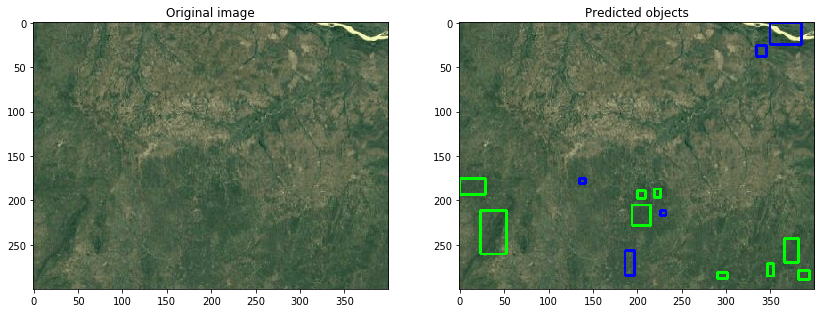

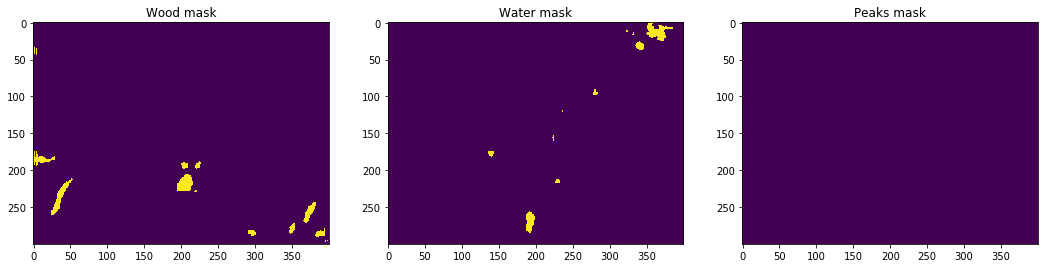

GOOD PREDICTIONS


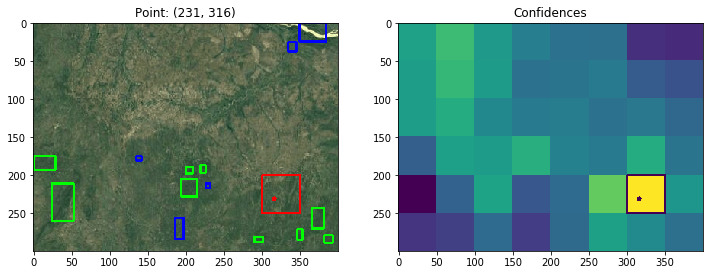

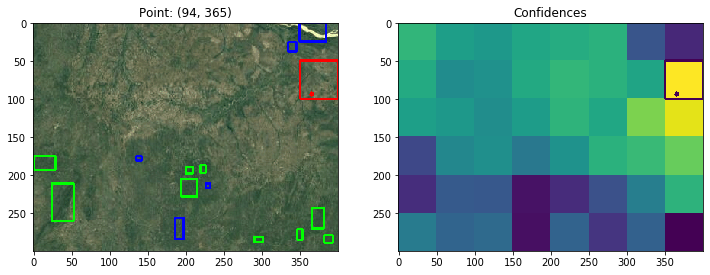

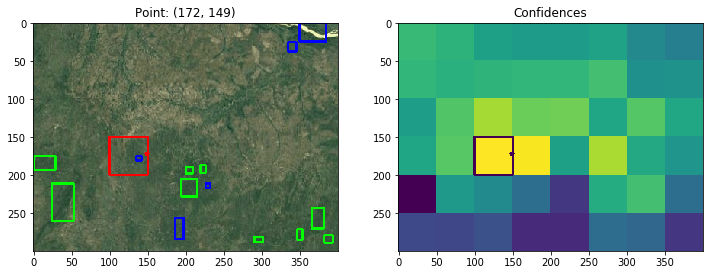

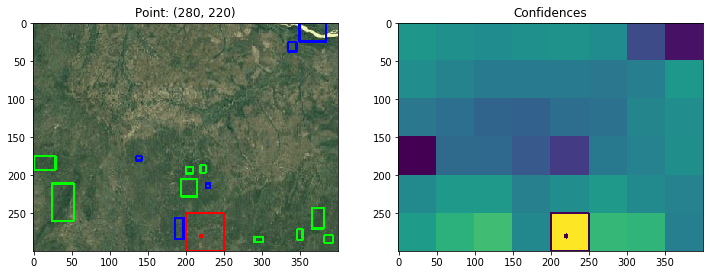

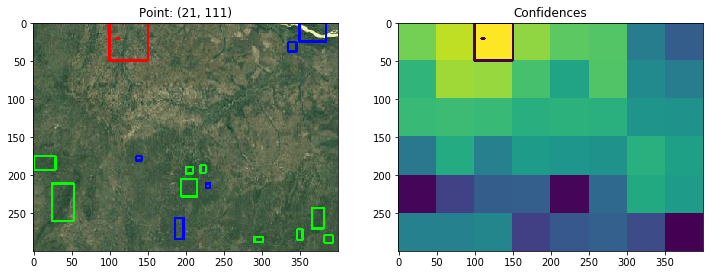

NOT GOOD PREDICTIONS


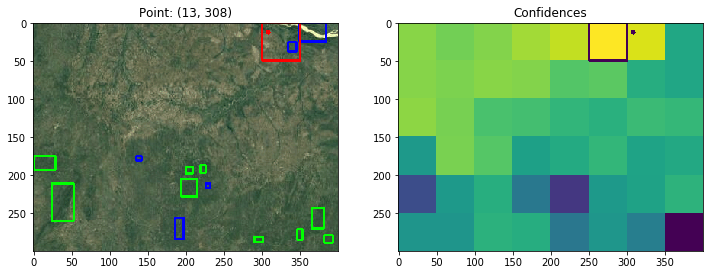

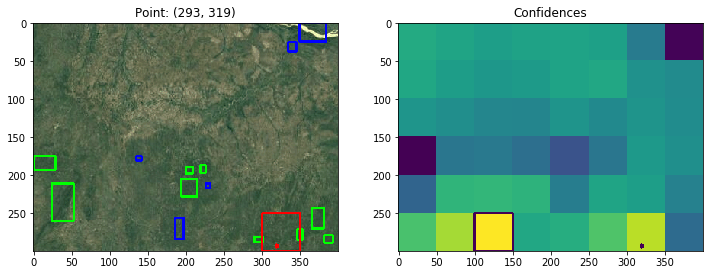

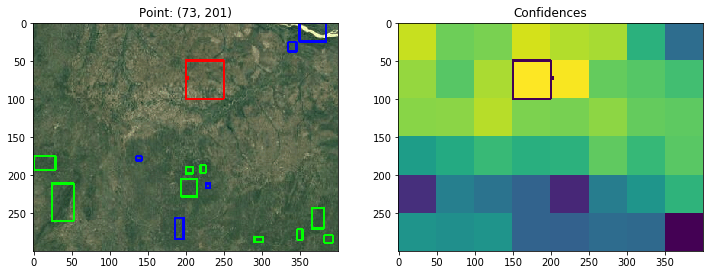

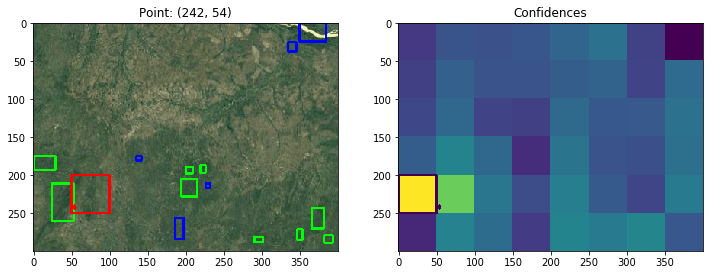

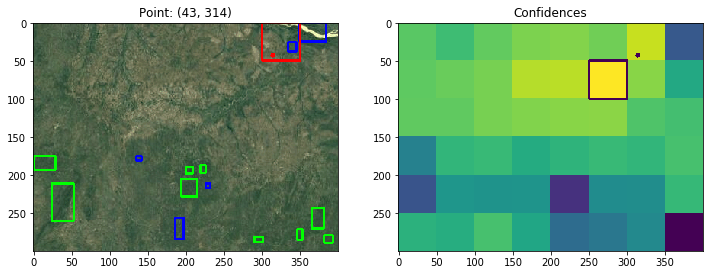

In [46]:
show_img(good_imgs[1], good_imgs_acc[1], good_is_in_1[1])

In [ ]:
# теперь "плохие"

ACCURACY: 0.34
['peak', 'peak', 'peak', 'peak']


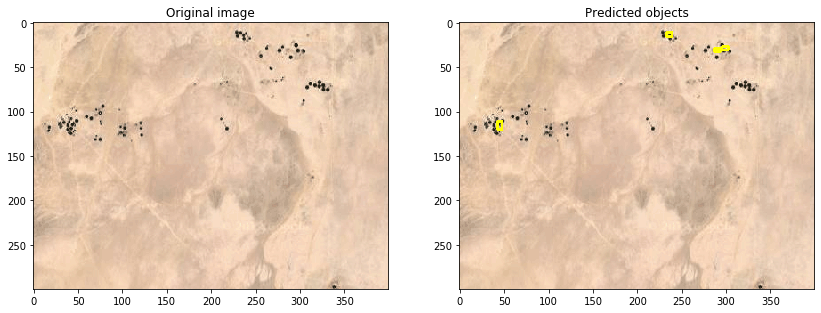

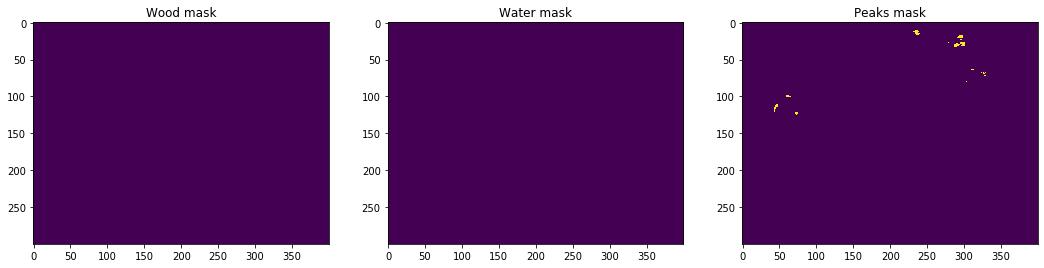

../utils.py:39: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


GOOD PREDICTIONS


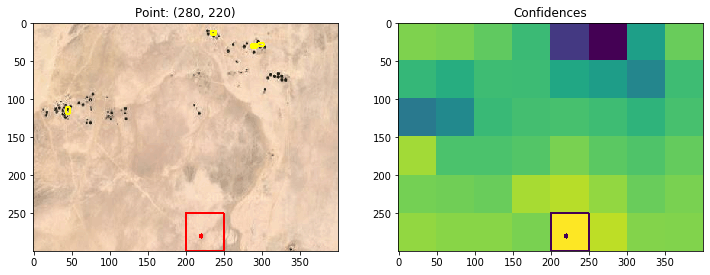

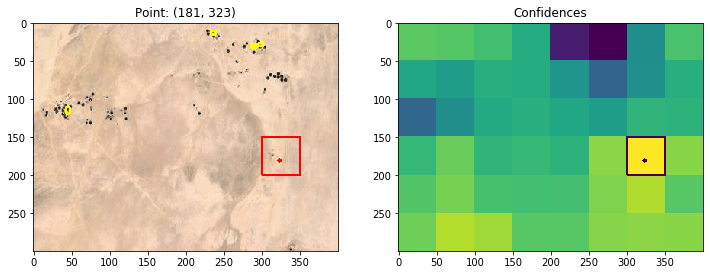

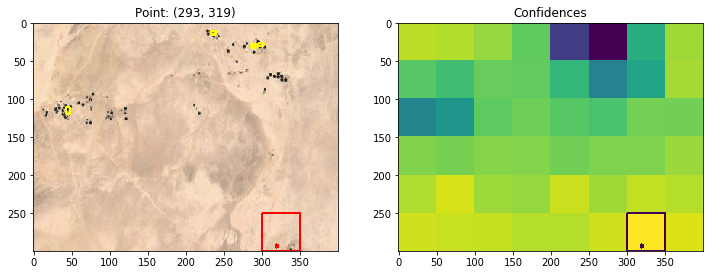

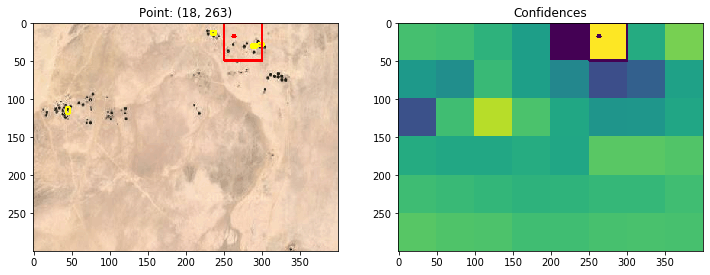

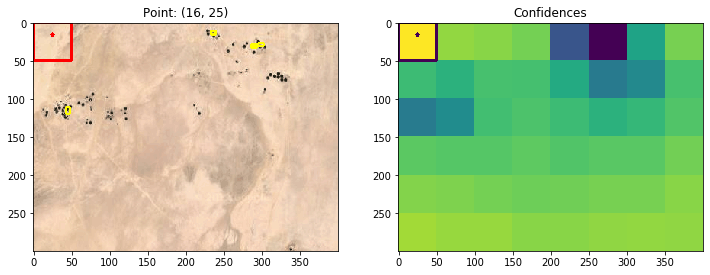

NOT GOOD PREDICTIONS


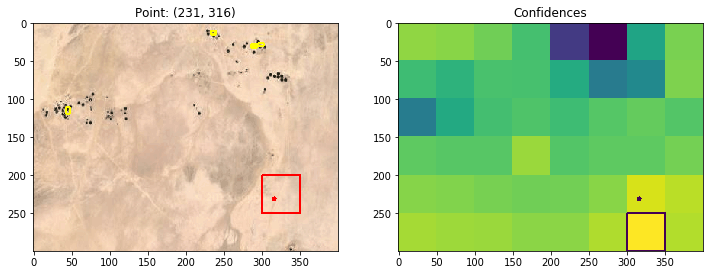

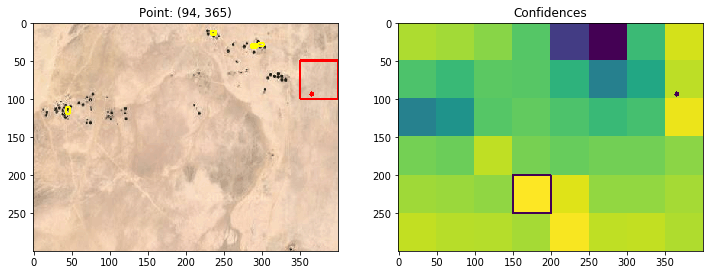

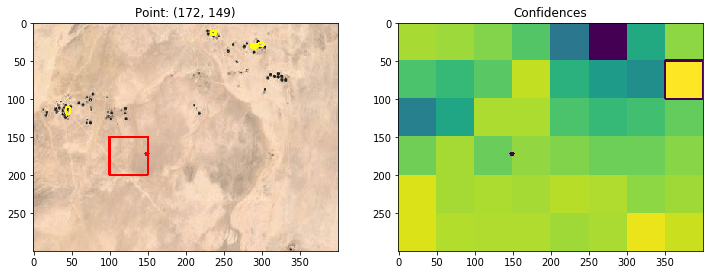

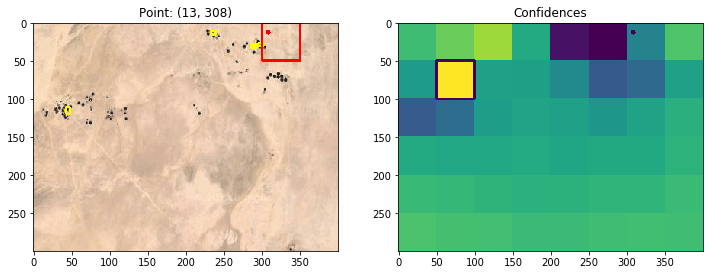

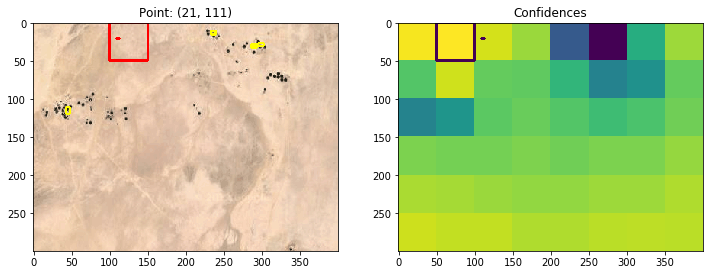

In [47]:
show_img(bad_imgs[0], bad_imgs_acc[0], bad_is_in_1[0])

ACCURACY: 0.34
['wood', 'water', 'water']


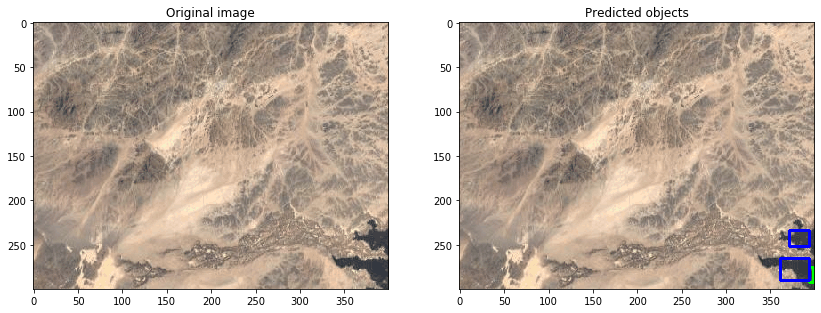

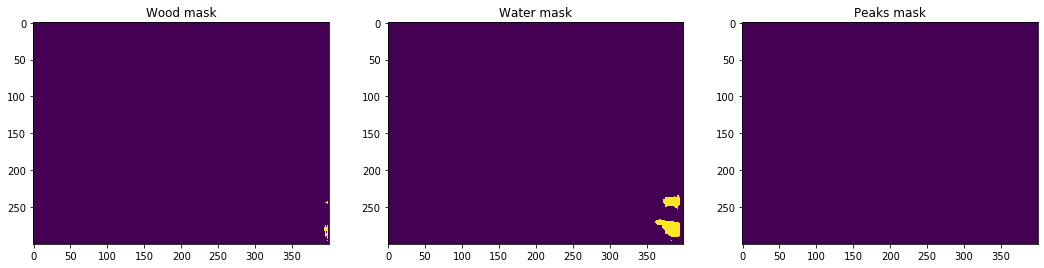

GOOD PREDICTIONS


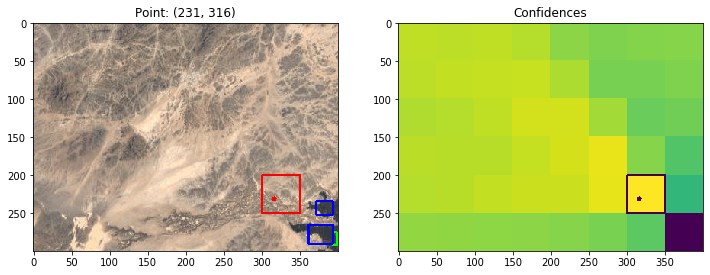

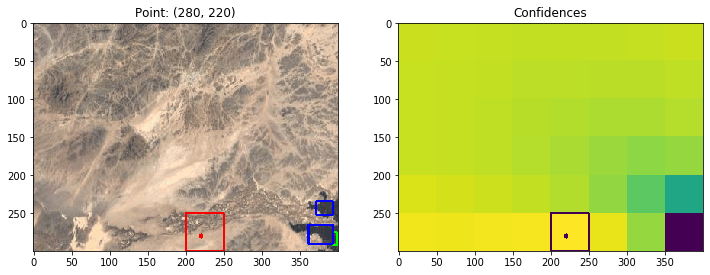

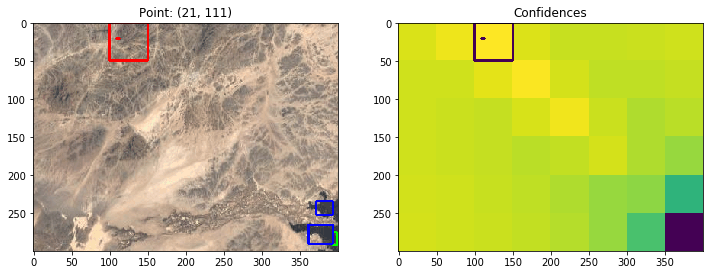

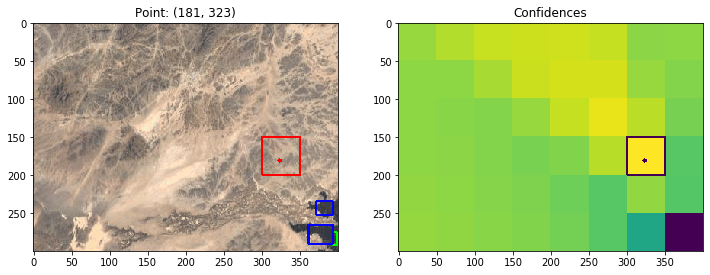

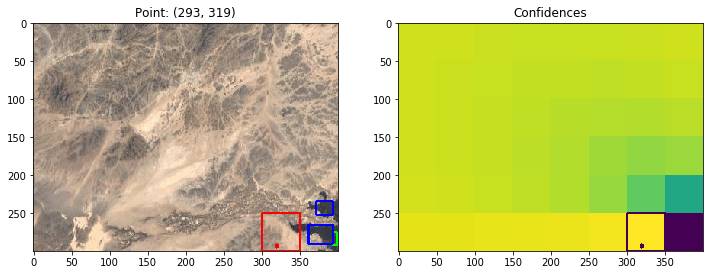

NOT GOOD PREDICTIONS


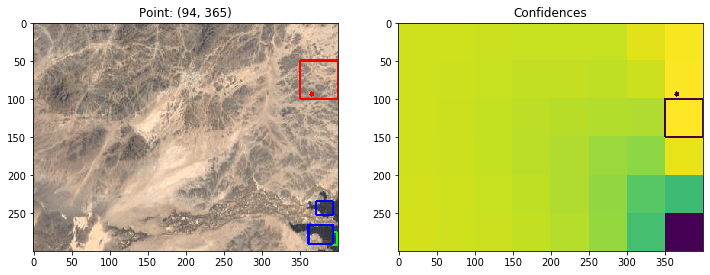

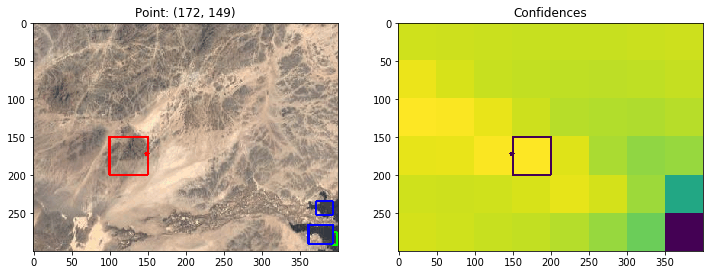

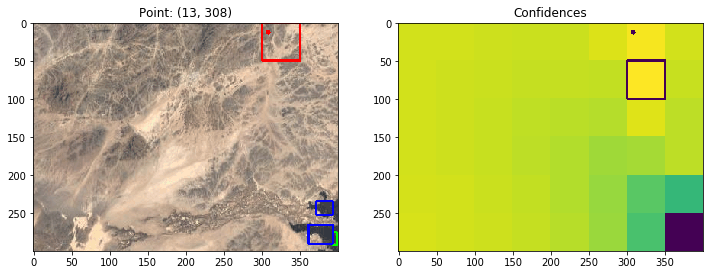

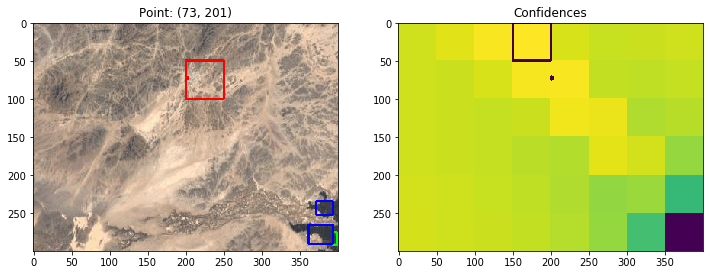

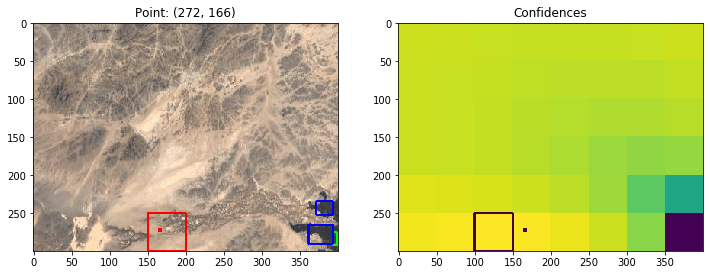

In [48]:
show_img(bad_imgs[1], bad_imgs_acc[1], bad_is_in_1[1])

ACCURACY: 0.31
['water', 'water', 'water']


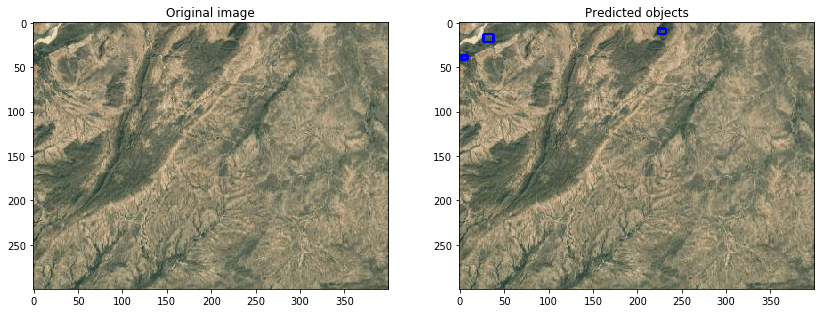

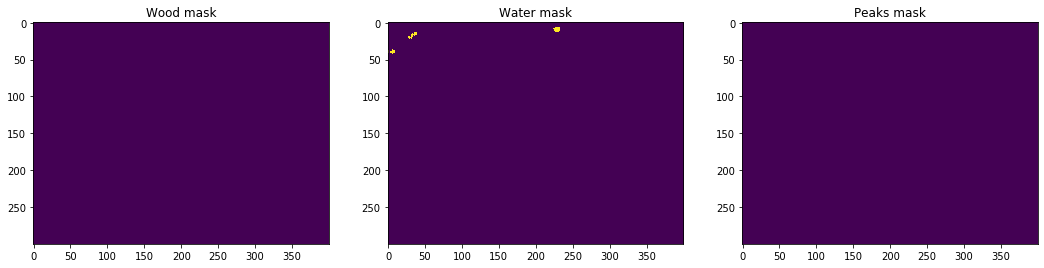

GOOD PREDICTIONS


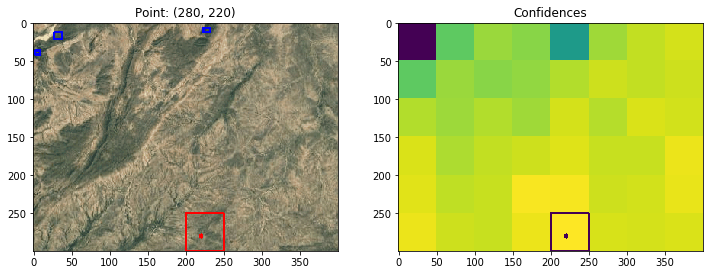

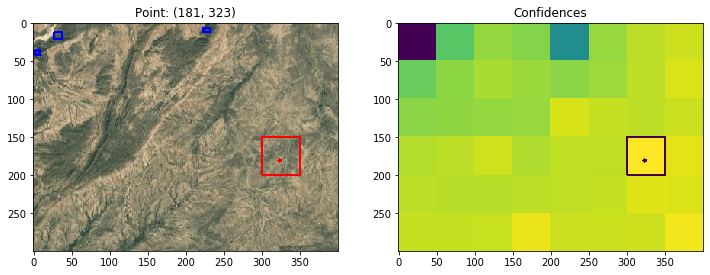

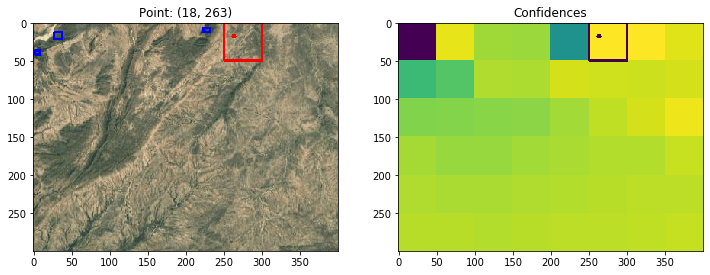

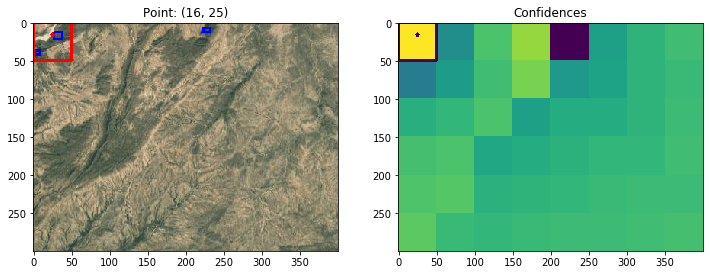

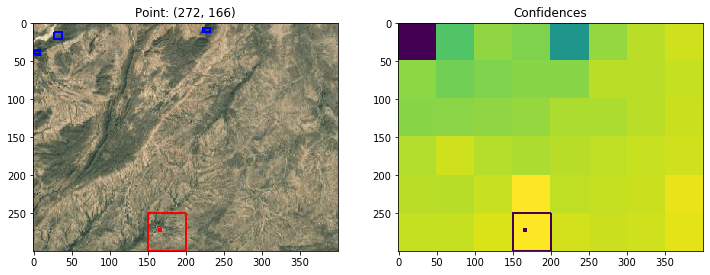

NOT GOOD PREDICTIONS


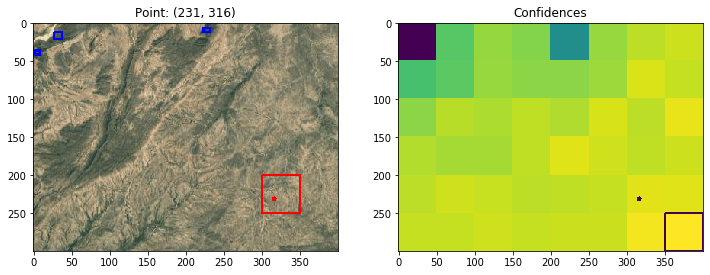

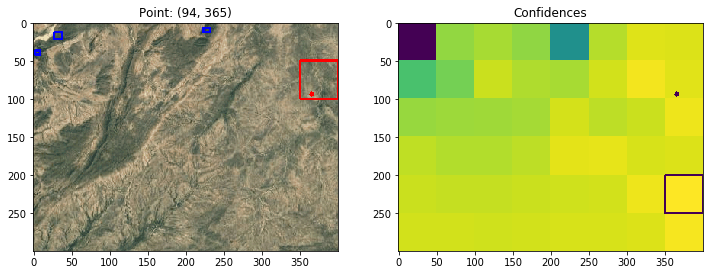

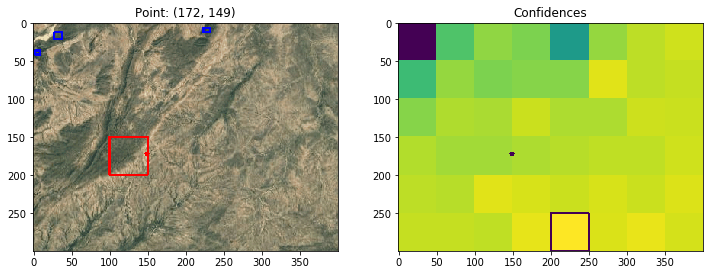

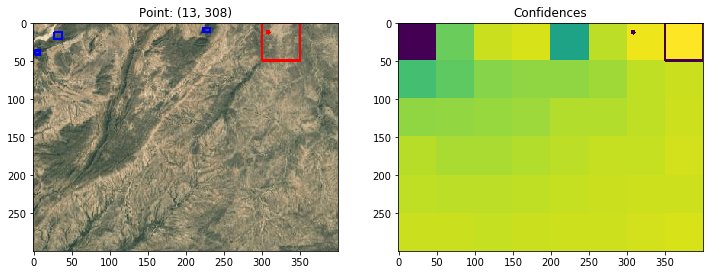

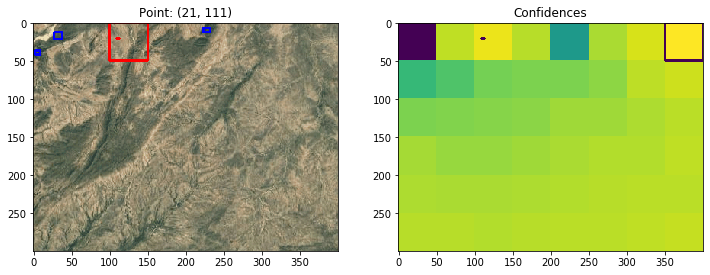

In [49]:
show_img(bad_imgs[2], bad_imgs_acc[2], bad_is_in_1[2])

Плохо получается, когда объекты одинакового размера и все в одном углу. Единственное решение здесь - использовать больше картинок со сдвигами по координатам, чтобы было больше информации.

Ещё частые непопадания - нахождение на границе квадрата. Тут решение - использовать более мелкое разбиение.